# Analysis of SBC of SpecletSeven

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from theano import tensor as tt

In [116]:
import src.exceptions
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.globals import PYMC3
from src.io import cache_io, data_io
from src.loggers import logger
from src.modeling import pymc3_analysis as pmanal
from src.modeling import pymc3_sampling_api as pmapi
from src.modeling import simulation_based_calibration_helpers as sbc
from src.plot.color_pal import FitMethodColors, ModelColors, SeabornColor

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(
    gg.theme_bw()
    + gg.theme(
        figure_size=(4, 4),
        axis_ticks_major=gg.element_blank(),
        strip_background=gg.element_blank(),
    )
)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

In [11]:
sbc_summary_dir = data_io.project_root_dir() / "cache" / "sbc-cache"

all_sbc_results = [p.name for p in sbc_summary_dir.iterdir()]
all_sbc_results.sort()
all_sbc_results

['sp2-default_ADVI_collated-posterior-summaries.pkl',
 'sp2-default_MCMC_collated-posterior-summaries.pkl',
 'sp4-centered-copynum_ADVI_collated-posterior-summaries.pkl',
 'sp4-centered-copynum_MCMC_collated-posterior-summaries.pkl',
 'sp4-default-config_ADVI_collated-posterior-summaries.pkl',
 'sp4-default-config_MCMC_collated-posterior-summaries.pkl',
 'sp4-default-fullrank_ADVI_collated-posterior-summaries.pkl',
 'sp4-default_ADVI_collated-posterior-summaries.pkl',
 'sp4-default_MCMC_collated-posterior-summaries.pkl',
 'sp4-noncentered-copynum_ADVI_collated-posterior-summaries.pkl',
 'sp4-noncentered-copynum_MCMC_collated-posterior-summaries.pkl',
 'sp4-noncentered_ADVI_collated-posterior-summaries.pkl',
 'sp4-noncentered_MCMC_collated-posterior-summaries.pkl',
 'sp5-default_ADVI_collated-posterior-summaries.pkl',
 'sp5-default_MCMC_collated-posterior-summaries.pkl',
 'sp5-noncentered_ADVI_collated-posterior-summaries.pkl',
 'sp5-noncentered_MCMC_collated-posterior-summaries.pkl',
 

In [19]:
sp7_sbc_results = [p for p in sbc_summary_dir.iterdir() if "sp7" in p.name]
sp7_sbc_results = [p for p in sp7_sbc_results if "MCMC" in p.name]
sp7_sbc_results.sort()
sp7_sbc_results

[PosixPath('/n/data1/hms/dbmi/park/Cook/speclet/cache/sbc-cache/sp7-cellline-cn-ncp_MCMC_collated-posterior-summaries.pkl'),
 PosixPath('/n/data1/hms/dbmi/park/Cook/speclet/cache/sbc-cache/sp7-cellline-cn_MCMC_collated-posterior-summaries.pkl'),
 PosixPath('/n/data1/hms/dbmi/park/Cook/speclet/cache/sbc-cache/sp7-default_MCMC_collated-posterior-summaries.pkl'),
 PosixPath('/n/data1/hms/dbmi/park/Cook/speclet/cache/sbc-cache/sp7-intercept-noncentered_MCMC_collated-posterior-summaries.pkl')]

In [26]:
sp7_sbc_summary_dict = {
    p.name.replace("_collated-posterior-summaries.pkl", ""): p for p in sp7_sbc_results
}

## Poor estimates in "sp7-cellline-cn_MCMC"

In [79]:
ODD_SIM = "sim_id_0011"

cellline_cn_post = (
    pd.read_pickle(sp7_sbc_summary_dict["sp7-cellline-cn_MCMC"])
    .reset_index()
    .assign(odd_sim=lambda d: d.simulation_id == ODD_SIM)
)
cellline_cn_post.head()

,parameter,parameter_name,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,true_value,simulation_id,within_hdi,odd_sim
0,μ_μ_h,μ_μ_h,3.625,0.142,3.386,3.769,0.042,0.031,13.0,1673.0,1.22,3.528105,sim_id_0000,True,False
1,"μ_h[0,0]",μ_h,4.384,0.091,4.223,4.492,0.019,0.013,28.0,731.0,1.10,4.311403,sim_id_0000,True,False
2,"μ_h[0,1]",μ_h,5.345,0.097,5.180,5.497,0.004,0.003,577.0,928.0,1.56,5.321524,sim_id_0000,True,False
3,"μ_h[1,0]",μ_h,5.096,0.081,4.951,5.216,0.004,0.002,544.0,771.0,1.56,5.022738,sim_id_0000,True,False
4,"μ_h[1,1]",μ_h,2.793,0.100,2.620,2.926,0.018,0.013,39.0,861.0,1.08,2.745975,sim_id_0000,True,False


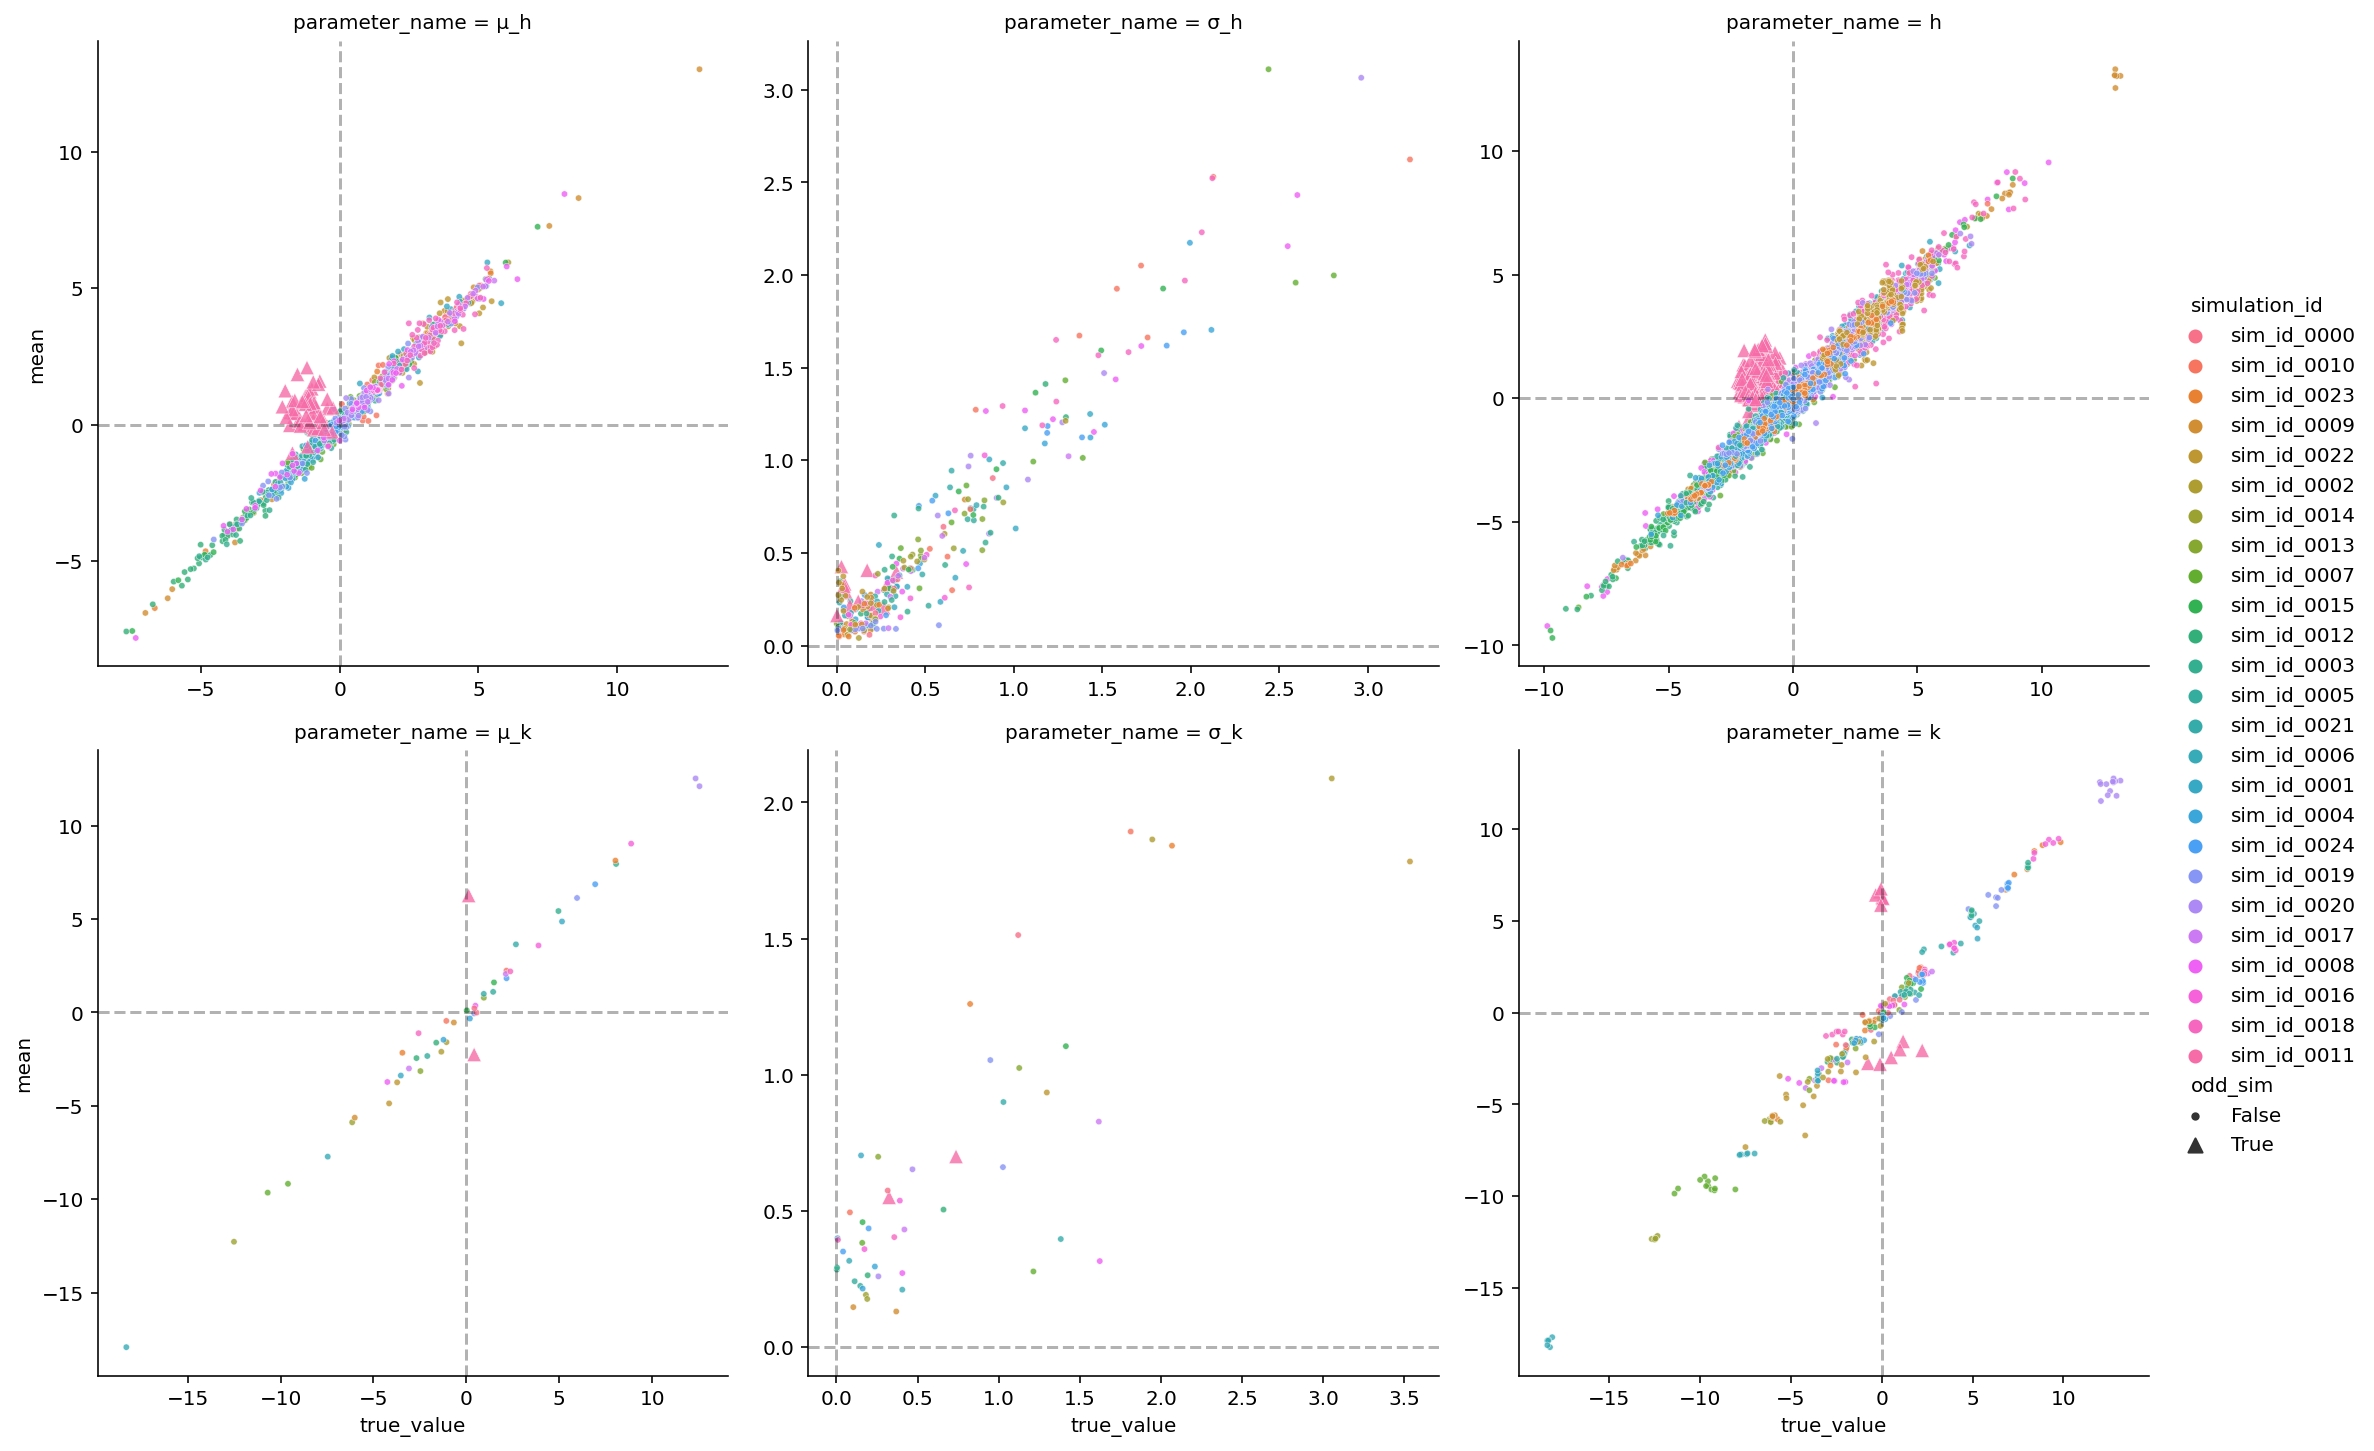

In [106]:
var_names = ["μ_h", "σ_h", "h", "μ_k", "σ_k", "k"]


def sort_call(x: pd.Series) -> pd.Series:
    tbl = {v: i for i, v in enumerate(var_names)}
    y = pd.Series([tbl[v] for v in x])
    return y


fg = sns.relplot(
    data=cellline_cn_post[cellline_cn_post.parameter_name.isin(var_names)]
    .sort_values("odd_sim", ascending=True)
    .sort_values("parameter_name", key=sort_call),
    x="true_value",
    y="mean",
    hue="simulation_id",
    style="odd_sim",
    size="odd_sim",
    markers={True: "^", False: "o"},
    sizes={True: 50, False: 10},
    alpha=0.8,
    col="parameter_name",
    kind="scatter",
    col_wrap=3,
    facet_kws={"sharex": False, "sharey": False},
)

for ax in fg.axes.flatten():
    line_kwargs = {"color": "k", "linestyle": "--", "alpha": 0.3}
    ax.axvline(0, **line_kwargs)
    ax.axhline(0, **line_kwargs)

plt.show()

In [119]:
def load_sbc_results(
    model_name: str, perm_num: int
) -> tuple[pd.DataFrame, sbc.SBCResults, sbc.SBCFileManager]:
    sbc_path = speclet_intermediate_dir / model_name / f"sbc-perm{perm_num}"
    sbc_results_fm = sbc.SBCFileManager(sbc_path)

    if sbc_results_fm.all_data_exists():
        sbc_data = sbc_results_fm.get_sbc_data()
        sbc_res = sbc_results_fm.get_sbc_results()
        return sbc_data, sbc_res, sbc_results_fm
    else:
        raise src.exceptions.CacheDoesNotExistError()

In [120]:
sbc11_data, sbc11_res, _ = load_sbc_results("sp7-cellline-cn_MCMC", 11)

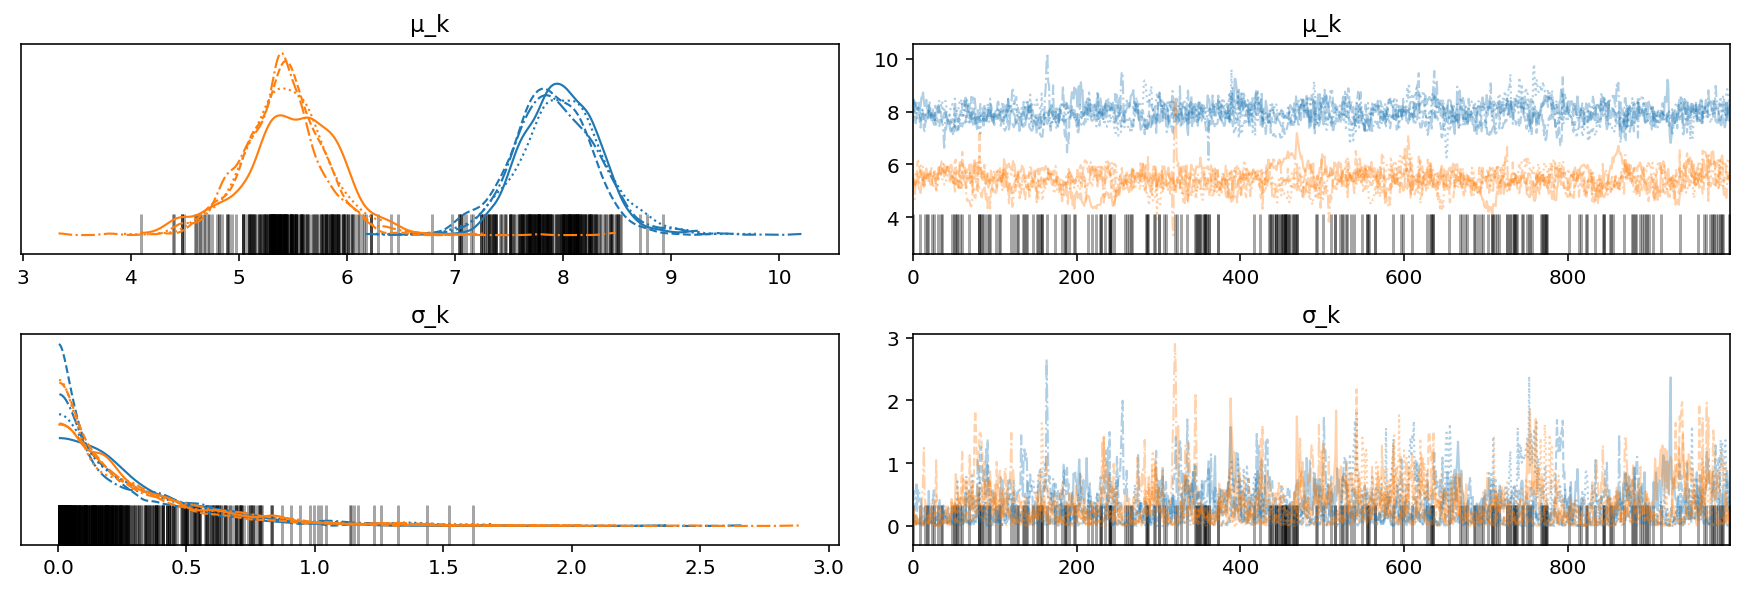

In [121]:
az.plot_trace(sbc11_res.inference_obj, var_names=["μ_k", "σ_k"]);

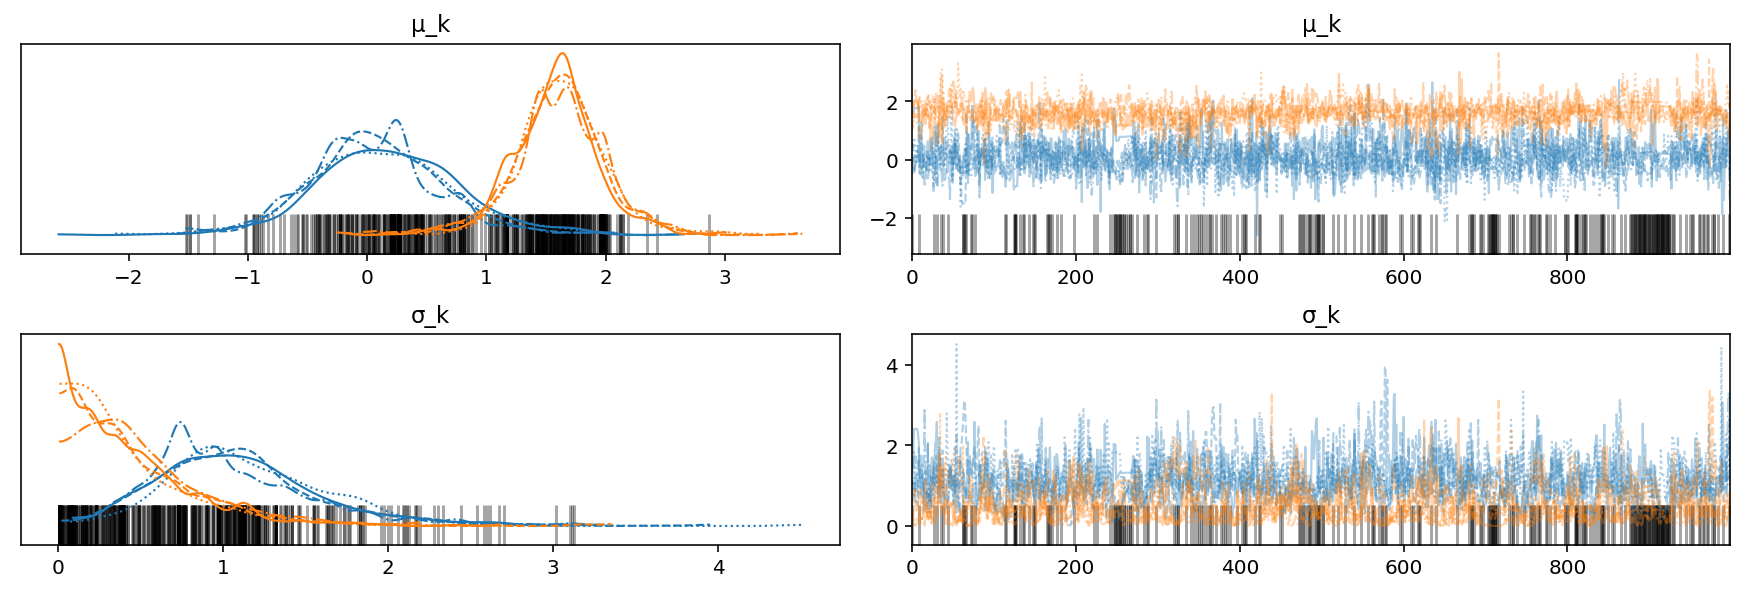

In [129]:
sbc_other_data, sbc_other_res, _ = load_sbc_results("sp7-cellline-cn_MCMC", 22)
az.plot_trace(sbc_other_res.inference_obj, var_names=["μ_k", "σ_k"]);

---

In [ ]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

In [ ]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m